<center>
<h2>DV2599 - PROJECT</h2>
<h3>Predicting Payment date</h3>
<h4>
Rasmus Dunder - radn21@student.bth.se
</h4>
<h4>
Rasmus Johansson - rajo22@student.bth.se
</h4>
</center>

#### Import modules / libraries

In [58]:
import pandas as pd

# Ignore warnings messages in prints
import warnings
warnings.filterwarnings("ignore")

#### Import the data and clean

In [59]:
#Importing the dataset
df = pd.read_csv('dataset.csv')

#Dropping not needed columns
df = df.drop(columns=['name_customer', 'buisness_year', 'invoice_currency', 'doc_id','posting_id', 'area_business','document type', 'baseline_create_date', 'document_create_date.1', 'document_create_date'])

# Print ratio of open/closed invoices
not_yetpayed = df['isOpen'].value_counts().sort_index()
quality_ratios = round((not_yetpayed / not_yetpayed.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {not_yetpayed}")

# Move all not payed invoices to its own dataset
df_predict = df[df['isOpen'] == 1]
df_predict_looking = df_predict.copy()
df_predict = df_predict.drop(columns=['clear_date'])

# Drop all Columns where invoice is not yet paid
df = df[df['isOpen'] == 0]

#Printing the amount of nullvalues in the dataset
print(f"\nNull values in the dataset: {sum(df.isnull().sum(axis=1))}\n")

#Dropping the nullvalues
df.dropna(inplace=True)

#Dropping the duplicates from the datasets
df.drop_duplicates(subset=['invoice_id'], inplace=True)
df_predict.drop_duplicates(subset=['invoice_id'], inplace=True)

#Removing now not needed columns
df = df.drop(columns=['invoice_id', 'isOpen'])
df_predict = df_predict.drop(columns=['invoice_id', 'isOpen'])

#Making all dates the same type
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')
df['clear_date'] = pd.to_datetime(df['clear_date'],  errors='coerce')
df['posting_date'] = pd.to_datetime(df['posting_date'], format='%m/%d/%Y')
df_predict['due_in_date'] = pd.to_datetime(df_predict['due_in_date'], format='%Y%m%d')
df_predict['posting_date'] = pd.to_datetime(df_predict['posting_date'], format='%m/%d/%Y')

# Drop Columns where due_in_date is before posting date
df = df[df['due_in_date'] >= df['posting_date']]
df_predict = df_predict[df_predict['due_in_date'] >= df_predict['posting_date']]

#Creating 3 new columns
df['payment_term'] = (df['due_in_date'] - df['posting_date']).dt.days
df['delayed_payment_days'] = (df['clear_date'] - df['due_in_date']).dt.days
df['payed_on_time'] = df['delayed_payment_days'] <= 0
df_predict['payment_term'] = (df_predict['due_in_date'] - df_predict['posting_date']).dt.days

Ratios: isOpen
0    80.0
1    20.0
Name: count, dtype: float64
Counts: isOpen
0    40000
1    10000
Name: count, dtype: int64

Null values in the dataset: 6



In [60]:
from scipy import stats
from sklearn.preprocessing import LabelEncoder

#Checking for ratio on True/False
payed_time = df['payed_on_time'].value_counts().sort_index()
quality_ratios = round((payed_time / payed_time.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {payed_time}")

# Relabeling cust_number
label_encoder = LabelEncoder()
df['cust_number'] = label_encoder.fit_transform(df['cust_number'])
df_predict['cust_number'] = label_encoder.fit_transform(df_predict['cust_number'])

# Relabeling cust_payment_terms
label_encoder = LabelEncoder()
df['cust_payment_terms'] = label_encoder.fit_transform(df['cust_payment_terms'])
df_predict['cust_payment_terms'] = label_encoder.fit_transform(df_predict['cust_payment_terms'])

# Relabeling business_code
label_encoder = LabelEncoder()
df['business_code'] = label_encoder.fit_transform(df['business_code'])
df_predict['business_code'] = label_encoder.fit_transform(df_predict['business_code'])

simulated_todays_date = df['clear_date'].max()

# Making two different datasets, one for true false predictions and one for regression
df_payement_days = df.copy()
df_payement_ontime = df.copy()
df_payement_days = df_payement_days.drop(columns=['payed_on_time','clear_date'])
df_payement_ontime = df_payement_ontime.drop(columns=['delayed_payment_days','clear_date'])

Ratios: payed_on_time
False    41.76
True     58.24
Name: count, dtype: float64
Counts: payed_on_time
False    16308
True     22740
Name: count, dtype: int64


### Splitting and Scaling of the data

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Relabeling payed_on_time
label_encoder = LabelEncoder()
df_payement_ontime['payed_on_time'] = label_encoder.fit_transform(df_payement_ontime['payed_on_time'])

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = df_payement_ontime.iloc[:, :-1]
y = df_payement_ontime.iloc[:,-1:]

# Split data
date_X_train, date_X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)
secs_X_train, secs_X_test = date_X_train.copy(), date_X_test.copy()


# Splitting dates into year, month, days
for col in ['posting_date', 'due_in_date']:
    date_X_train[f'{col}_year'] = date_X_train[col].dt.year
    date_X_train[f'{col}_month'] = date_X_train[col].dt.month
    date_X_train[f'{col}_day'] = date_X_train[col].dt.day

    date_X_test[f'{col}_year'] = date_X_test[col].dt.year
    date_X_test[f'{col}_month'] = date_X_test[col].dt.month
    date_X_test[f'{col}_day'] = date_X_test[col].dt.day

# Drop the original date columns if no longer needed
date_X_train.drop(columns=['posting_date', 'due_in_date'], inplace=True)
date_X_test.drop(columns=['posting_date', 'due_in_date'], inplace=True)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
date_scaled_values_train = scaler.fit_transform(date_X_train[columns])
date_scaled_values_test = scaler.transform(date_X_test[columns])
secs_scaled_values_train = scaler.fit_transform(secs_X_train[columns])
secs_scaled_values_test = scaler.transform(secs_X_test[columns])

#Add the scaled columns to the DataFrame with new column names
for i, col in enumerate(columns):
    date_X_train[f"{col}"] = date_scaled_values_train[:, i]
    date_X_test[f"{col}"] = date_scaled_values_test[:, i]
    secs_X_train[f"{col}"] = secs_scaled_values_train[:, i]
    secs_X_test[f"{col}"] = secs_scaled_values_test[:, i]

#Setting dates values into seconds from a specific time
secs_X_train['posting_date'] = secs_X_train['posting_date'].astype('int64') // 10**9
secs_X_test['posting_date'] = secs_X_test['posting_date'].astype('int64') // 10**9
secs_X_train['due_in_date'] = secs_X_train['due_in_date'].astype('int64') // 10**9
secs_X_test['due_in_date'] = secs_X_test['due_in_date'].astype('int64') // 10**9



### Performing KFold validations tests

##### Dates as month/day/year

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score

import numpy as np

rkf = RepeatedKFold(n_splits= 2, n_repeats= 5)
date_knn_f1_scores = cross_val_score(KNeighborsClassifier(), date_X_train, y_train, cv= rkf, scoring="f1")
date_rdf_f1_scores = cross_val_score(RandomForestClassifier(), date_X_train, y_train, cv= rkf, scoring="f1")
date_gdb_f1_scores = cross_val_score(GradientBoostingClassifier(), date_X_train, y_train, cv= rkf, scoring="f1")

#Rounds all scores to 4 decimals
for i,x in enumerate(date_gdb_f1_scores):
    date_gdb_f1_scores[i] = round(x,4)

for i,x in enumerate(date_rdf_f1_scores):
    date_rdf_f1_scores[i] = round(x,4)

for i,x in enumerate(date_knn_f1_scores):
    date_knn_f1_scores[i] = round(x,4)

## Calculating mean and standard deviation
date_knn_mean_f1 = round(sum(date_knn_f1_scores)/len(date_knn_f1_scores),4)
date_rdf_mean_f1 = round(sum(date_rdf_f1_scores)/len(date_rdf_f1_scores),4)
date_gdb_mean_f1 = round(sum(date_gdb_f1_scores)/len(date_gdb_f1_scores),4)
date_knn_std_deviation_f1 = round(np.std(date_knn_f1_scores),4)
date_rdf_std_deviation_f1 = round(np.std(date_rdf_f1_scores),4)
date_gdb_std_deviation_f1 = round(np.std(date_gdb_f1_scores),4)

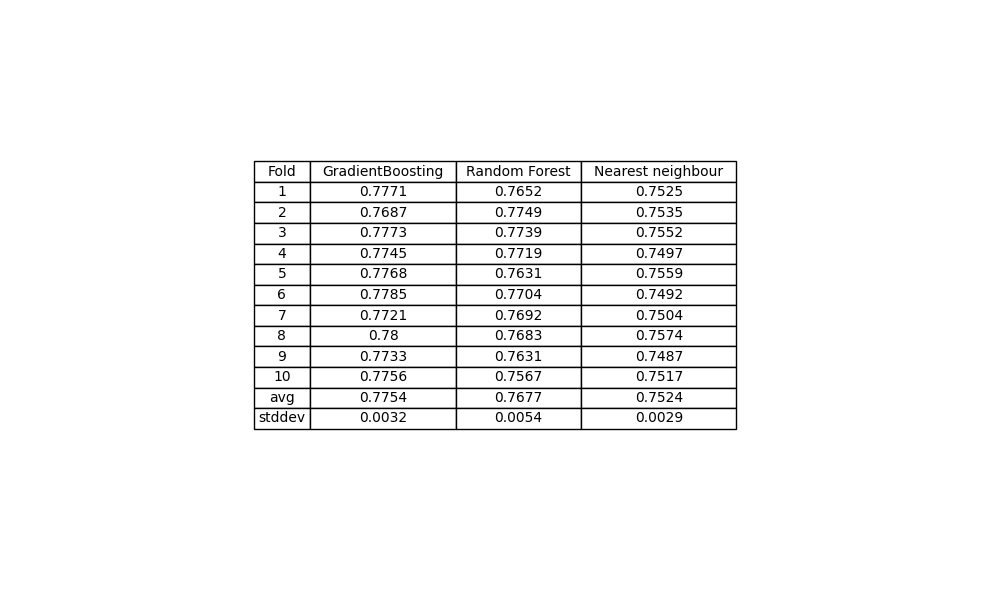

In [63]:
import matplotlib.pyplot as plt

data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': date_gdb_f1_scores,
    'Random Forest': date_rdf_f1_scores,
    'Nearest neighbour': date_knn_f1_scores,
}
avg = ['avg',date_gdb_mean_f1,date_rdf_mean_f1,date_knn_mean_f1]
stddev = ['stddev',date_gdb_std_deviation_f1,date_rdf_std_deviation_f1,date_knn_std_deviation_f1]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

##### Dates as seconds from January 1970

In [64]:
rkf = RepeatedKFold(n_splits= 2, n_repeats= 5, random_state=42)
secs_knn_f1_scores = cross_val_score(KNeighborsClassifier(), secs_X_train, y_train, cv= rkf, scoring="f1")
secs_rdf_f1_scores = cross_val_score(RandomForestClassifier(), secs_X_train, y_train, cv= rkf, scoring="f1")
secs_gdb_f1_scores = cross_val_score(GradientBoostingClassifier(), secs_X_train, y_train, cv= rkf, scoring="f1")

#Rounds all scores to 4 decimals
for i,x in enumerate(secs_gdb_f1_scores):
    secs_gdb_f1_scores[i] = round(x,4)

for i,x in enumerate(secs_rdf_f1_scores):
    secs_rdf_f1_scores[i] = round(x,4)

for i,x in enumerate(secs_knn_f1_scores):
    secs_knn_f1_scores[i] = round(x,4)

## Calculating mean and standard deviation
secs_knn_mean_f1 = round(sum(secs_knn_f1_scores)/len(secs_knn_f1_scores),4)
secs_rdf_mean_f1 = round(sum(secs_rdf_f1_scores)/len(secs_rdf_f1_scores),4)
secs_gdb_mean_f1 = round(sum(secs_gdb_f1_scores)/len(secs_gdb_f1_scores),4)
secs_knn_std_deviation_f1 = round(np.std(secs_knn_f1_scores),4)
secs_rdf_std_deviation_f1 = round(np.std(secs_rdf_f1_scores),4)
secs_gdb_std_deviation_f1 = round(np.std(secs_gdb_f1_scores),4)

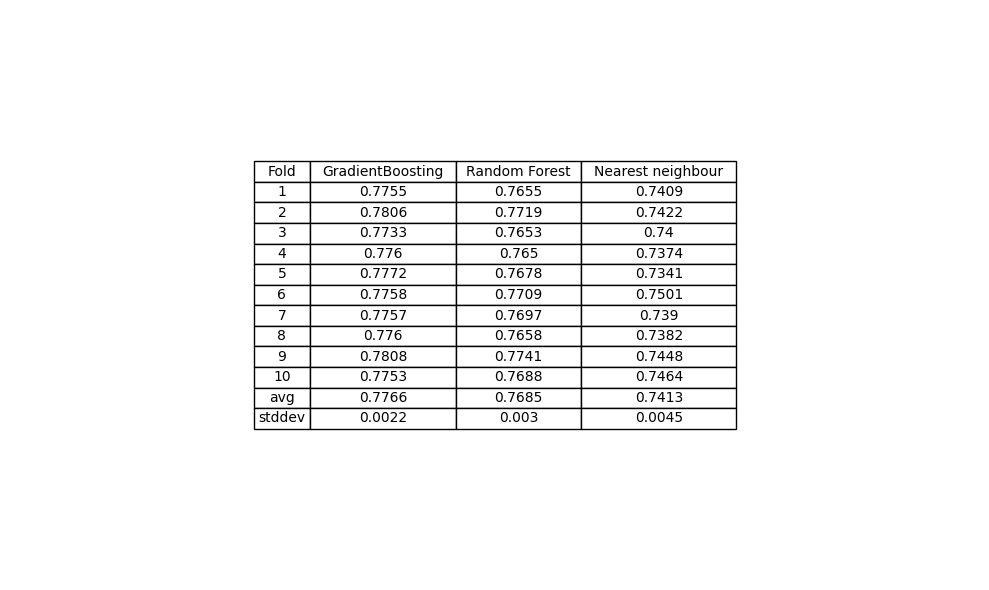

In [65]:
## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': secs_gdb_f1_scores,
    'Random Forest': secs_rdf_f1_scores,
    'Nearest neighbour': secs_knn_f1_scores,
}
avg = ['avg',secs_gdb_mean_f1,secs_rdf_mean_f1,secs_knn_mean_f1]
stddev = ['stddev',secs_gdb_std_deviation_f1,secs_rdf_std_deviation_f1,secs_knn_std_deviation_f1]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

### Ranking the tests and plotting ranktables

##### Dates as month/day/year

In [66]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(date_knn_f1_scores)):
    
    knn = date_knn_f1_scores[i]
    rdf = date_rdf_f1_scores[i]
    gdb = date_gdb_f1_scores[i]
    
    if knn >= rdf and knn >= gdb:
        knn_rank = 1
        if rdf >= gdb:
            rdf_rank = 2
            gdb_rank = 3
        else:
            rdf_rank = 3
            gdb_rank = 2
    elif rdf >= knn and rdf >= gdb:
        rdf_rank = 1
        if knn >= gdb:
            knn_rank = 2
            gdb_rank = 3
        else:
            knn_rank = 3
            gdb_rank = 2
    else:
        gdb_rank = 1
        if knn >= rdf:
            knn_rank = 2
            rdf_rank = 3
        else:
            knn_rank = 3
            rdf_rank = 2

    ranks.append([gdb_rank,rdf_rank,knn_rank])

## Calculating a average rank

date_avg_knn_f1_scores = 0
date_avg_rdf_f1_scores = 0
date_avg_gdb_f1_scores = 0

for x in ranks:
    date_avg_gdb_f1_scores += x[0]
    date_avg_rdf_f1_scores += x[1]
    date_avg_knn_f1_scores += x[2]

date_avg_gdb_f1_scores = date_avg_gdb_f1_scores/len(ranks)
date_avg_rdf_f1_scores = date_avg_rdf_f1_scores/len(ranks)
date_avg_knn_f1_scores = date_avg_knn_f1_scores/len(ranks)

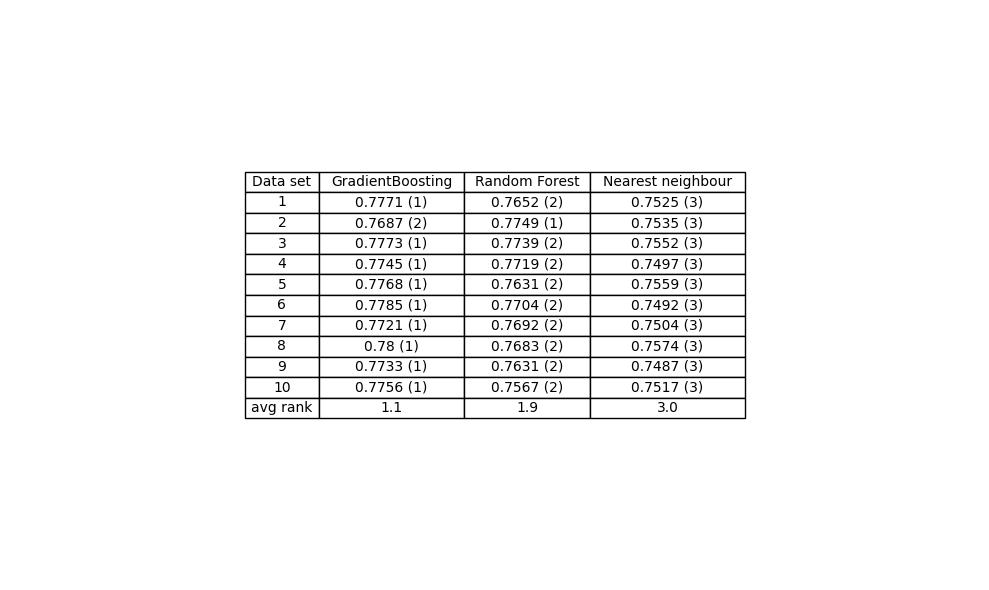

In [67]:
## Making a new Dataframe that looks like table 12.8 in main literature

gdb_string = []
rdf_string = []
knn_string = []

for i in range(len(ranks)):
    gdb_string.append(str(date_gdb_f1_scores[i]) + " (" + str(ranks[i][0]) + ")")
    rdf_string.append(str(date_rdf_f1_scores[i]) + " (" + str(ranks[i][1]) + ")")
    knn_string.append(str(date_knn_f1_scores[i]) + " (" + str(ranks[i][2]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': gdb_string,
    'Random Forest': rdf_string,
    'Nearest neighbour': knn_string,
}
avg = ['avg rank',date_avg_gdb_f1_scores,date_avg_rdf_f1_scores,date_avg_knn_f1_scores]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

##### Dates as seconds from January 1970

In [68]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(secs_knn_f1_scores)):
    
    knn = secs_knn_f1_scores[i]
    rdf = secs_rdf_f1_scores[i]
    gdb = secs_gdb_f1_scores[i]
    
    if knn >= rdf and knn >= gdb:
        knn_rank = 1
        if rdf >= gdb:
            rdf_rank = 2
            gdb_rank = 3
        else:
            rdf_rank = 3
            gdb_rank = 2
    elif rdf >= knn and rdf >= gdb:
        rdf_rank = 1
        if knn >= gdb:
            knn_rank = 2
            gdb_rank = 3
        else:
            knn_rank = 3
            gdb_rank = 2
    else:
        gdb_rank = 1
        if knn >= rdf:
            knn_rank = 2
            rdf_rank = 3
        else:
            knn_rank = 3
            rdf_rank = 2

    ranks.append([gdb_rank,rdf_rank,knn_rank])

## Calculating a average rank

secs_avg_knn_f1_scores = 0
secs_avg_rdf_f1_scores = 0
secs_avg_gdb_f1_scores = 0

for x in ranks:
    secs_avg_gdb_f1_scores += x[0]
    secs_avg_rdf_f1_scores += x[1]
    secs_avg_knn_f1_scores += x[2]

secs_avg_gdb_f1_scores = secs_avg_gdb_f1_scores/len(ranks)
secs_avg_rdf_f1_scores = secs_avg_rdf_f1_scores/len(ranks)
secs_avg_knn_f1_scores = secs_avg_knn_f1_scores/len(ranks)

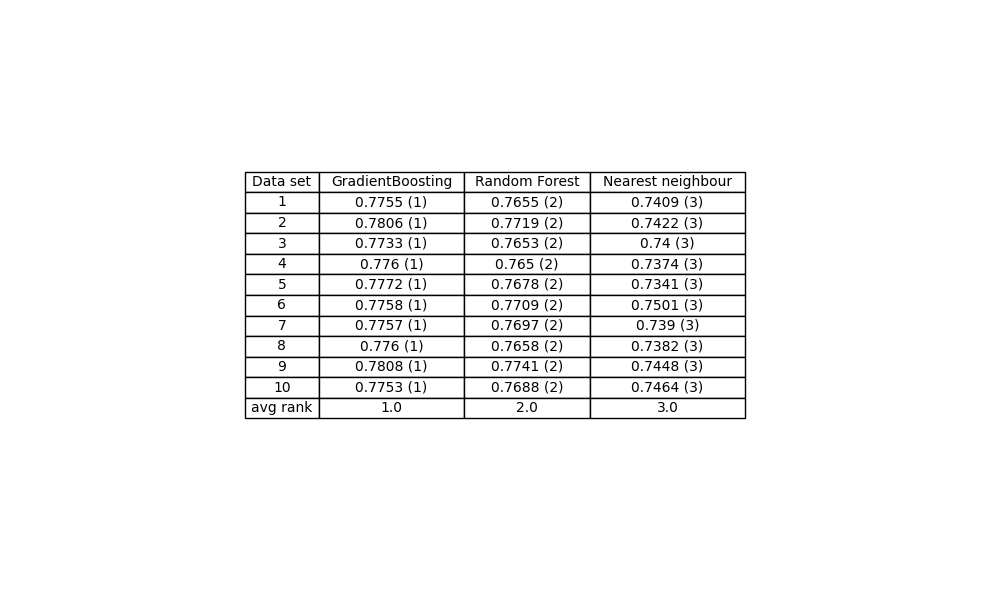

In [69]:
gdb_string = []
rdf_string = []
knn_string = []

for i in range(len(ranks)):
    gdb_string.append(str(secs_gdb_f1_scores[i]) + " (" + str(ranks[i][0]) + ")")
    rdf_string.append(str(secs_rdf_f1_scores[i]) + " (" + str(ranks[i][1]) + ")")
    knn_string.append(str(secs_knn_f1_scores[i]) + " (" + str(ranks[i][2]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': gdb_string,
    'Random Forest': rdf_string,
    'Nearest neighbour': knn_string,
}
avg = ['avg rank',secs_avg_gdb_f1_scores,secs_avg_rdf_f1_scores,secs_avg_knn_f1_scores]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))


### Conducting the Friedman and Nemenyi Tests

In [70]:
import math

# Declaring variables
k = 3
n = len(ranks)

## Calculating Friedman formulas
avg_rank = (k+1)/2
sum_sqd_secs = n * ((secs_avg_gdb_f1_scores - avg_rank)**2 + (secs_avg_rdf_f1_scores - avg_rank)**2 + (secs_avg_knn_f1_scores - avg_rank)**2)
sum_sqd_date = n * ((date_avg_gdb_f1_scores - avg_rank)**2 + (date_avg_rdf_f1_scores - avg_rank)**2 + (date_avg_knn_f1_scores - avg_rank)**2)


##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

#Printing the results
print(f"The sum sqared difference for Dates: {sum_sqd_secs}")
print(f"The sum sqared difference for Secs: {sum_sqd_date}")
print(f"The Nemenyi Score: {nem_score}")

The sum sqared difference for Dates: 20.0
The sum sqared difference for Secs: 18.2
The Nemenyi Score: 1.0478214542564015


In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score


# Splitting dates into year, month, days
for col in ['posting_date', 'due_in_date']:
    X[f'{col}_year'] = X[col].dt.year
    X[f'{col}_month'] = X[col].dt.month
    X[f'{col}_day'] = X[col].dt.day

# Drop the original date columns if no longer needed
X.drop(columns=['posting_date', 'due_in_date'], inplace=True)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(X[columns])
X_scaled = X.copy()

#Add the scaled columns to the DataFrame with new column names
for i, col in enumerate(columns):
    X_scaled[f"{col}"] = scaled_values_train[:, i]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rfc_grid = [
    {'n_estimators': 50, 'max_depth': 5},
    {'n_estimators': 50, 'max_depth': 15},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 15},
    {'n_estimators': 200, 'max_depth': 15},
    {'n_estimators': 200, 'max_depth': 5},
]

gdb_grid = [
    {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5},
    {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3},
    {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5},
]

rfc_results = []
gdb_results = []

# Do k-fold tests for each setting 
for i in range(len(rfc_grid)):
    rfc_f1 = []
    gdb_f1 = []

    #Conduct k-fold test

    for train_index, test_index in kf.split(X_scaled): 
        
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
        rfc = RandomForestClassifier(**rfc_grid[i], random_state=42)
        gdb = GradientBoostingClassifier(**gdb_grid[i], random_state=42)

        
        rfc.fit(X_train, y_train)
        gdb.fit(X_train, y_train)

        
        rfc_y_pred = rfc.predict(X_test)
        rfc_f1.append(f1_score(y_test, rfc_y_pred))

        gdb_y_pred = gdb.predict(X_test)
        gdb_f1.append(f1_score(y_test, gdb_y_pred))

    
    rfc_results.append({'params': rfc_grid[i], 'f1_score': np.mean(rfc_f1)})
    gdb_results.append({'params': gdb_grid[i], 'f1_score': np.mean(gdb_f1)})

In [72]:
print("Random Forest Results:")
for res in rfc_results:
    print(f"Params: {res['params']}, F1 Score: {res['f1_score']:.4f}")

print("\nGradient Boosting Results:")
for res in gdb_results:
    print(f"Params: {res['params']}, F1 Score: {res['f1_score']:.4f}")

Random Forest Results:
Params: {'n_estimators': 50, 'max_depth': 5}, F1 Score: 0.7617
Params: {'n_estimators': 50, 'max_depth': 15}, F1 Score: 0.7944
Params: {'n_estimators': 100, 'max_depth': 10}, F1 Score: 0.7872
Params: {'n_estimators': 100, 'max_depth': 15}, F1 Score: 0.7973
Params: {'n_estimators': 200, 'max_depth': 15}, F1 Score: 0.7979
Params: {'n_estimators': 200, 'max_depth': 5}, F1 Score: 0.7617

Gradient Boosting Results:
Params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}, F1 Score: 0.7696
Params: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5}, F1 Score: 0.7836
Params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}, F1 Score: 0.7999
Params: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}, F1 Score: 0.7695
Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}, F1 Score: 0.7906
Params: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5}, F1 Score: 0.8000


In [73]:
from sklearn.metrics import roc_curve, auc

class_x_train, class_X_test, class_y_train, class_y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)


rfc = RandomForestClassifier(n_estimators = 200, max_depth = 15, random_state=42)
gdb = GradientBoostingClassifier(n_estimators =  200, learning_rate =  0.1, max_depth= 5, random_state=42)

# Train models
rfc.fit(class_x_train, class_y_train)
gdb.fit(class_x_train, class_y_train)

# Predict and calculate F1-scores
rfc_y_pred = rfc.predict(class_X_test)
rfc_y_proba = rfc.predict_proba(class_X_test)[:, 1]
rfc_f1 = f1_score(class_y_test, rfc_y_pred)
rfc_ac = accuracy_score(class_y_test, rfc_y_pred)

gdb_y_pred = gdb.predict(class_X_test)
gdb_y_proba = gdb.predict_proba(class_X_test)[:, 1]
gdb_f1 = f1_score(class_y_test, gdb_y_pred)
gdb_ac = accuracy_score(class_y_test, gdb_y_pred)

print(round(rfc_f1,4))
print(round(rfc_ac,4))
print(round(gdb_f1,4))
print(round(gdb_ac,4))

rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(class_y_test, rfc_y_proba)
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(class_y_test, gdb_y_proba)

gbc_roc_auc = auc(rfc_fpr, rfc_tpr)
rfc_roc_auc = auc(gbc_fpr, gbc_tpr)

0.796
0.7408
0.8037
0.7577


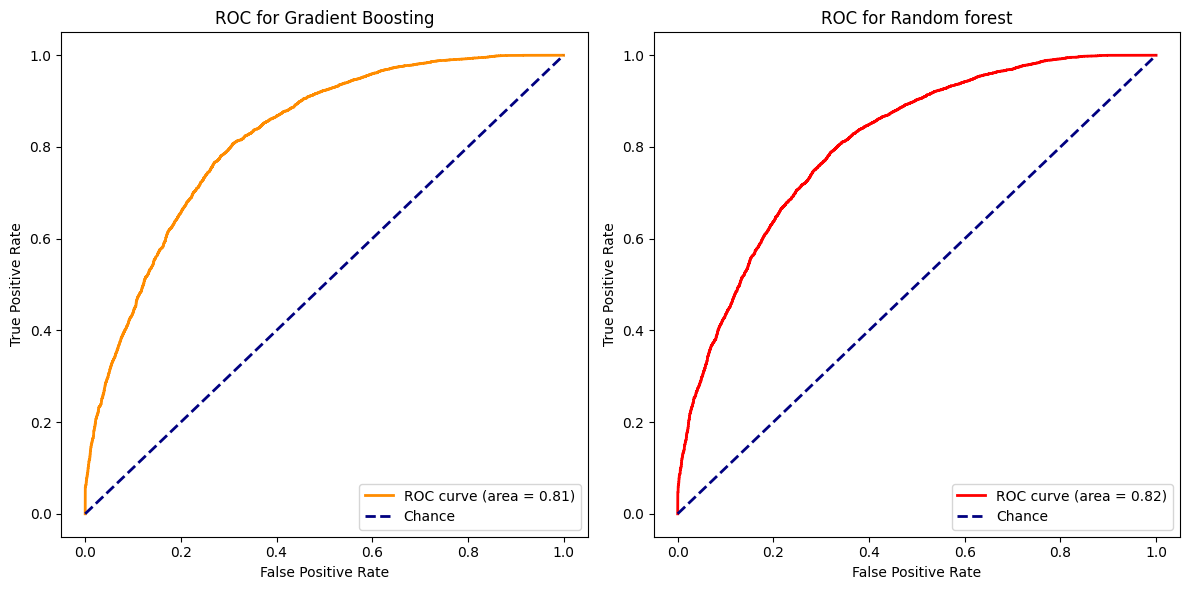

In [74]:
#Plot the ROC curves
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Plot the first curve
axs[0].plot(gbc_fpr, gbc_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {gbc_roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC for Gradient Boosting')
axs[0].legend(loc='lower right')

#Plot the second curve
axs[1].plot(rfc_fpr, rfc_tpr, color='red', lw=2, label=f'ROC curve (area = {rfc_roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC for Random forest')
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [75]:
final_predictions = rfc_y_pred

##### Plotting the predictions of the test_set

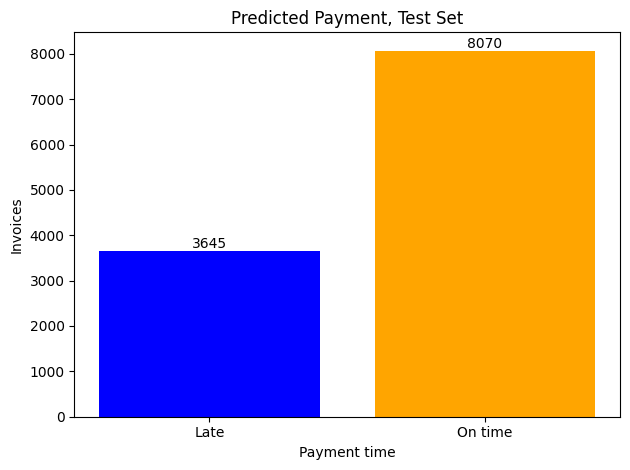

In [76]:
count_0 = np.sum(final_predictions == 0)
count_1 = np.sum(final_predictions == 1)

# Data for the bar chart
labels = ['Late', 'On time']
counts = [count_0, count_1]

# Create the bar chart
bars =  plt.bar(labels, counts, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Payment time')
plt.ylabel('Invoices')
plt.title('Predicted Payment, Test Set')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

##### Preparing the not payed invoices dataset

In [77]:
df_predict_date = df_predict.copy()

# Changing dates into year, month, day
for col in ['posting_date', 'due_in_date']:
    df_predict_date[f'{col}_year'] = df_predict_date[col].dt.year
    df_predict_date[f'{col}_month'] = df_predict_date[col].dt.month
    df_predict_date[f'{col}_day'] = df_predict_date[col].dt.day

# Drop the original date columns if no longer needed
df_predict_date.drop(columns=['posting_date', 'due_in_date'], inplace=True)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_test = scaler.fit_transform(df_predict_date[columns])

#Add the scaled columns to the DataFrame with new column names
for i, col in enumerate(columns):
    df_predict_date[f"{col}"] = scaled_values_test[:, i]

#### Does predictions on the unpayed invoices

In [78]:
# Predictions for true/false

final_predictions_ontime = rfc.predict(df_predict_date)

#### Plotting the predictions of the unpayed invoices

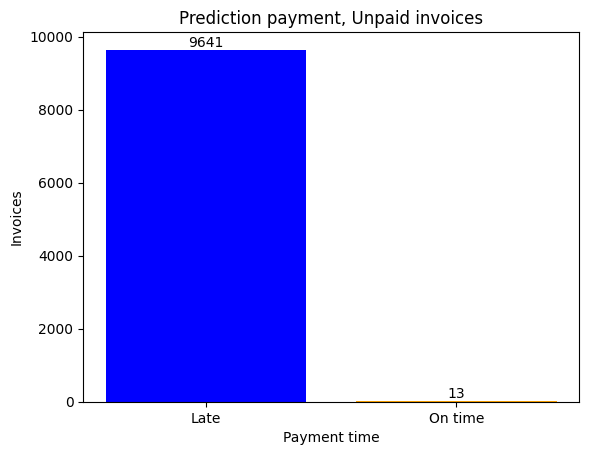

In [79]:
count_0 = np.sum(final_predictions_ontime == 0)
count_1 = np.sum(final_predictions_ontime == 1)

# Data for the bar chart
labels = ['Late', 'On time']
counts = [count_0, count_1]

# Create the bar chart
bars = plt.bar(labels, counts, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Payment time')
plt.ylabel('Invoices')
plt.title('Prediction payment, Unpaid invoices')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Show the chart
plt.show()

#### Removing invoices that was predicted to be on time

In [80]:
# Reset index to ensure clean DataFrames for both training and target
df_predict_date.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)

late_invoices = []
for i, x in enumerate(final_predictions_ontime):
    if x == 0:
        late_invoices.append(i)

print(f"\nNumber of late invoices: {len(late_invoices)}")

# Drop the rows corresponding to the outliers from both features and target
df_predict_date = X_train.drop(index=late_invoices)

# Reset indices after dropping outliers
df_predict_date.reset_index(drop=True, inplace=True)


Number of late invoices: 9641


### Part where the amount of days late on invoices will be looked at

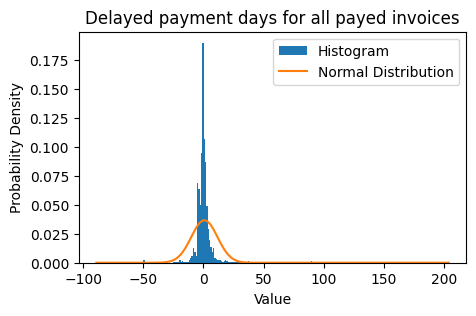

In [81]:
df_payement_dayslow = df_payement_days.copy()

#Calculating the widht size of the bins in the histogram
n = len(df_payement_dayslow['delayed_payment_days'])
bins = np.ceil((max(df_payement_dayslow['delayed_payment_days'])-min(df_payement_dayslow['delayed_payment_days']))/(3.5*np.std(df_payement_dayslow['delayed_payment_days'])/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(5, 3))
plt.hist(df_payement_dayslow['delayed_payment_days'], bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(df_payement_dayslow['delayed_payment_days'])
x = np.linspace(min(df_payement_dayslow['delayed_payment_days']), max(df_payement_dayslow['delayed_payment_days']), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Delayed payment days for all payed invoices')
plt.legend()
plt.show()

#### Splitting, checking for outliers and scaling the data

In [82]:
# Changing dates into year, month, day columns
for col in ['posting_date', 'due_in_date']:
    df_payement_dayslow[f'{col}_year'] = df_payement_dayslow[col].dt.year
    df_payement_dayslow[f'{col}_month'] = df_payement_dayslow[col].dt.month
    df_payement_dayslow[f'{col}_day'] = df_payement_dayslow[col].dt.day

##Drop the original date columns if no longer needed
df_payement_dayslow.drop(columns=['posting_date', 'due_in_date'], inplace=True)

df_positive_delaysa = df_payement_dayslow[df_payement_dayslow['delayed_payment_days'] > 0]

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = X = pd.concat([df_payement_dayslow.iloc[:, :5], df_payement_dayslow.iloc[:, 6:]], axis=1)
y = df_payement_days['delayed_payment_days']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(X_train[columns])
scaled_values_test = scaler.transform(X_test[columns])

# Combine the scaled values back into the DataFrame
X_train_scaled = X_train.copy()  # Copy the original training data
X_test_scaled = X_test.copy()  # Copy the original test data

# Replace the columns with scaled values
for i, col in enumerate(columns):
    X_train_scaled[col] = scaled_values_train[:, i]
    X_test_scaled[col] = scaled_values_test[:, i]

# Reset index to ensure clean DataFrames for both training and target
X_train_scaled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Calculate z-score for detecting outliers in the target (y_train)
df_zscore = stats.zscore(y_train)
outliers = []

# Identify outliers with a threshold of 2
threshold = 2
for i, x in enumerate(df_zscore):
    if abs(x) > threshold:
        outliers.append(i)

print(f"\nNumber of outliers: {len(outliers)}")

# Drop the rows corresponding to the outliers from both features and target
X_train_nooutlier = X_train_scaled.drop(index=outliers)
y_train_nooutlier = y_train.drop(index=outliers)

# Reset indices after dropping outliers
X_train_nooutlier.reset_index(drop=True, inplace=True)
y_train_nooutlier.reset_index(drop=True, inplace=True)


Number of outliers: 971


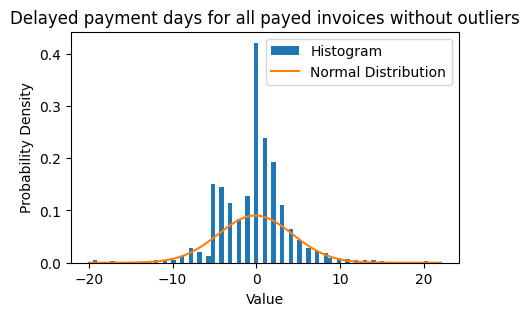

In [83]:
df_payement_dayslow = df_payement_days.copy()
#Calculating the widht size of the bins in the histogram
n = len(y_train_nooutlier)
bins = np.ceil((max(y_train_nooutlier)-min(y_train_nooutlier))/(3.5*np.std(y_train_nooutlier)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(5, 3))
plt.hist(y_train_nooutlier, bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(y_train_nooutlier)
x = np.linspace(min(y_train_nooutlier), max(y_train_nooutlier), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Delayed payment days for all payed invoices without outliers')
plt.show()

#### Conducting repeated kfold tests

In [84]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


rkf = RepeatedKFold(n_splits= 2, n_repeats= 5)
rfg_accuracy_scores = cross_val_score(RandomForestRegressor(), X_train, y_train, cv= rkf, scoring="neg_mean_squared_error")
gbr_accuracy_scores = cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv= rkf, scoring="neg_mean_squared_error")
svr_accuracy_scores = cross_val_score(LinearRegression(), X_train, y_train, cv= rkf, scoring="neg_mean_squared_error")

#Rounds all scores to 4 decimals
for i,x in enumerate(rfg_accuracy_scores):
    rfg_accuracy_scores[i] = -round(x,4)

for i,x in enumerate(gbr_accuracy_scores):
    gbr_accuracy_scores[i] = -round(x,4)

for i,x in enumerate(svr_accuracy_scores):
    svr_accuracy_scores[i] = -round(x,4)

In [85]:
## Calculating mean and standard deviation
lr_accuracy_scores = svr_accuracy_scores
rfg_mean_accuracy = round(sum(rfg_accuracy_scores)/len(rfg_accuracy_scores),4)
gbr_mean_accuracy = round(sum(gbr_accuracy_scores)/len(gbr_accuracy_scores),4)
lr_mean_accuracy = round(sum(lr_accuracy_scores)/len(lr_accuracy_scores),4)
rfg_std_deviation_accuracy = round(np.std(rfg_accuracy_scores),4)
gbr_std_deviation_accuracy = round(np.std(gbr_accuracy_scores),4)
lr_std_deviation_accuracy = round(np.std(lr_accuracy_scores),4)

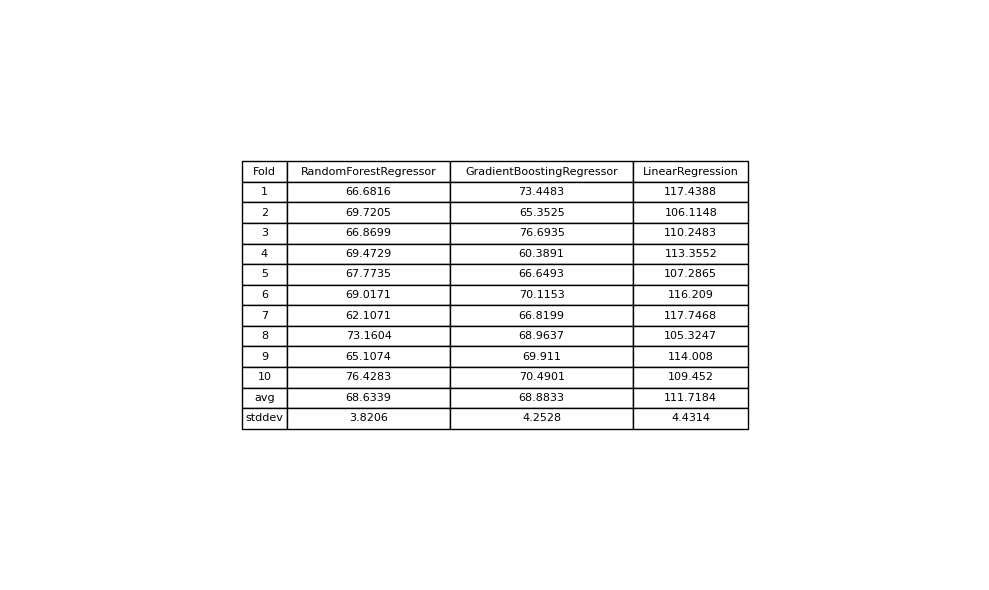

In [86]:
## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'RandomForestRegressor': rfg_accuracy_scores,
    'GradientBoostingRegressor': gbr_accuracy_scores,
    'LinearRegression': lr_accuracy_scores,
}

avg = ['avg',rfg_mean_accuracy,gbr_mean_accuracy,lr_mean_accuracy]
stddev = ['stddev',rfg_std_deviation_accuracy,gbr_std_deviation_accuracy,lr_std_deviation_accuracy]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

plt.show()

In [87]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(rfg_accuracy_scores)):
    
    rfg = rfg_accuracy_scores[i]
    gbr = gbr_accuracy_scores[i]
    lr = lr_accuracy_scores[i]
    if rfg <= gbr and rfg <= lr:
        rfg_rank = 1
        if gbr <= lr:
            gbr_rank = 2
            lr_rank = 3
        else:
            gbr_rank = 3
            lr_rank = 2
    elif gbr <= rfg and gbr <= lr:
        gbr_rank = 1
        if rfg <= lr:
            rfg_rank = 2
            lr_rank = 3
        else:
            rfg_rank = 3
            lr_rank = 2
    else:
        lr_rank = 1
        if rfg <= gbr:
            rfg_rank = 2
            gbr_rank = 3
        else:
            rfg_rank = 3
            gbr_rank = 2

    ranks.append([lr_rank,gbr_rank,rfg_rank])

## Calculating a average rank

avg_lr_accuracy = 0
avg_gbr_accuracy = 0
avg_rfg_accuracy = 0

for x in ranks:
    avg_lr_accuracy += x[0]
    avg_gbr_accuracy += x[1]
    avg_rfg_accuracy += x[2]

avg_lr_accuracy = avg_lr_accuracy/len(ranks)
avg_gbr_accuracy = avg_gbr_accuracy/len(ranks)
avg_rfg_accuracy = avg_rfg_accuracy/len(ranks)

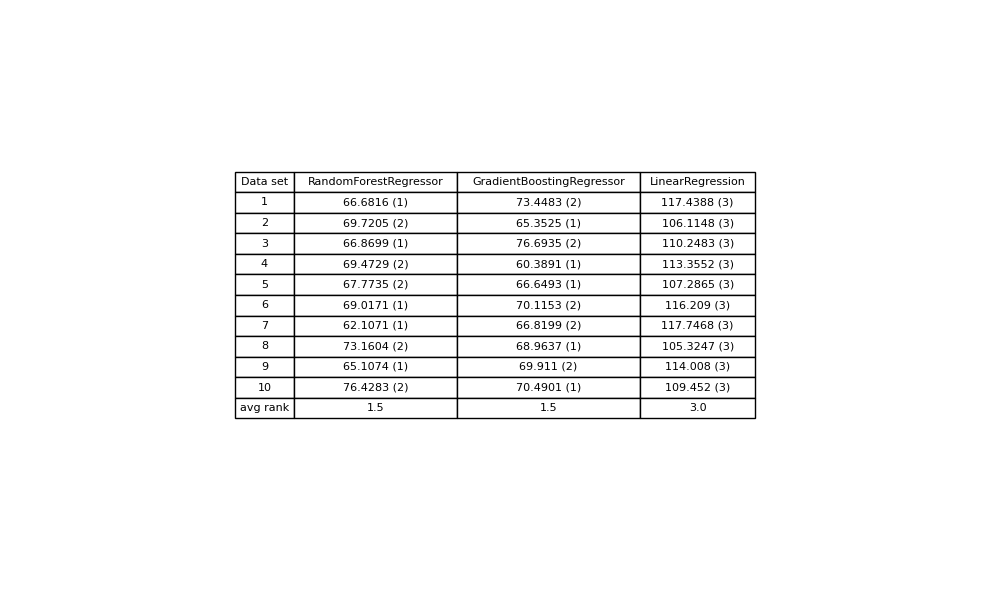

In [88]:
## Making a new Dataframe that looks like table 12.8 in main literature

rfg_string = []
gbr_string = []
lr_string = []

for i in range(len(ranks)):
    rfg_string.append(str(rfg_accuracy_scores[i]) + " (" + str(ranks[i][2]) + ")")
    gbr_string.append(str(gbr_accuracy_scores[i]) + " (" + str(ranks[i][1]) + ")")
    lr_string.append(str(lr_accuracy_scores[i]) + " (" + str(ranks[i][0]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'RandomForestRegressor': rfg_string,
    'GradientBoostingRegressor': gbr_string,
    'LinearRegression': lr_string,
}
avg = ['avg rank',avg_rfg_accuracy,avg_gbr_accuracy,avg_lr_accuracy]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

### Calculating Friedman and Nemenyia tests

In [89]:
import math

# Declaring variables
k = 3
n = len(ranks)

## Calculating Friedman formulas
avg_rank = (k+1)/2
sum_sqd = n * ((avg_rfg_accuracy - avg_rank)**2 + (avg_gbr_accuracy - avg_rank)**2 + (avg_lr_accuracy - avg_rank)**2)

##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

#Printing the results
print(f"The sum sqared difference for Secs: {sum_sqd}")
print(f"The Nemenyi Score: {nem_score}")

The sum sqared difference for Secs: 15.0
The Nemenyi Score: 1.0478214542564015


In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rfc_results = []
gdb_results = []

#Conduct kfold tests for each of the settings
for i in range(len(rfc_grid)):  # Match the grids
    rfr_MSE = []
    gdr_MSE = []

    #Conduct kfold test
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
        rfr = RandomForestRegressor(**rfc_grid[i], random_state=42)
        gdr = GradientBoostingRegressor(**gdb_grid[i], random_state=42)

        
        rfr.fit(X_train, y_train)
        gdr.fit(X_train, y_train)

        
        rfr_y_pred = rfr.predict(X_test)
        rfr_MSE.append(mean_squared_error(y_test, rfr_y_pred))

        gdr_y_pred = gdr.predict(X_test)
        gdr_MSE.append(mean_squared_error(y_test, gdr_y_pred))

    
    rfc_results.append({'params': rfc_grid[i], 'f1_score': np.mean(rfr_MSE)})
    gdb_results.append({'params': gdb_grid[i], 'f1_score': np.mean(gdr_MSE)})

In [91]:
print("Random Forest Results:")
for res in rfc_results:
    print(f"Params: {res['params']}, F1 Score: {res['f1_score']:.4f}")

print("\nGradient Boosting Results:")
for res in gdb_results:
    print(f"Params: {res['params']}, F1 Score: {res['f1_score']:.4f}")

Random Forest Results:
Params: {'n_estimators': 50, 'max_depth': 5}, F1 Score: 67.7907
Params: {'n_estimators': 50, 'max_depth': 15}, F1 Score: 61.2492
Params: {'n_estimators': 100, 'max_depth': 10}, F1 Score: 61.2070
Params: {'n_estimators': 100, 'max_depth': 15}, F1 Score: 60.7004
Params: {'n_estimators': 200, 'max_depth': 15}, F1 Score: 60.5637
Params: {'n_estimators': 200, 'max_depth': 5}, F1 Score: 67.8922

Gradient Boosting Results:
Params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}, F1 Score: 68.4624
Params: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5}, F1 Score: 65.6703
Params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}, F1 Score: 60.6188
Params: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}, F1 Score: 68.9669
Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}, F1 Score: 62.0593
Params: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5}, F1 Score: 61.1877


### Fitting the two best algortithms and testing them

In [92]:
rfr_outlier = RandomForestRegressor(n_estimators= 200 , max_depth=15, random_state=42)
gbr_outlier = GradientBoostingRegressor(n_estimators= 200, learning_rate = 0.1, max_depth=5, random_state=42)
rfr = RandomForestRegressor(n_estimators= 200 , max_depth=15, random_state=42)
gbr = GradientBoostingRegressor(n_estimators= 200, learning_rate = 0.1, max_depth=5, random_state=42)

# Train base models on training data
rfr_outlier.fit(X_train_nooutlier, y_train_nooutlier)
gbr_outlier.fit(X_train_nooutlier, y_train_nooutlier)
rfr.fit(X_train, y_train)
gbr.fit(X_train, y_train)

pred_rfr_outlier = rfr_outlier.predict(X_test)
pred_gbr_outlier = gbr_outlier.predict(X_test)
pred_rfr = rfr.predict(X_test)
pred_gbr = gbr.predict(X_test)

# Metrics
MSE_rfr_outlier = round(mean_squared_error(y_test, pred_rfr_outlier), 2)
MSE_gbr_outlier = round(mean_squared_error(y_test, pred_gbr_outlier), 2)
MSE_rfr = round(mean_squared_error(y_test, pred_rfr), 2)
MSE_gbr = round(mean_squared_error(y_test, pred_gbr), 2)

MAE_rfr_outlier = round(mean_absolute_error(y_test, pred_rfr_outlier), 2)
MAE_gbr_outlier = round(mean_absolute_error(y_test, pred_gbr_outlier), 2)
MAE_rfr = round(mean_absolute_error(y_test, pred_rfr), 2)
MAE_gbr = round(mean_absolute_error(y_test, pred_gbr), 2)

print("RandomForestRegressor no outliers MSE:", MSE_rfr_outlier)
print("RandomForestRegressor no outliers MAE:", MAE_rfr_outlier)
print("GradientBoostingRegressor no outliers MSE:", MSE_gbr_outlier)
print("GradientBoostingRegressor no outliers MAE:", MAE_gbr_outlier)

print("RandomForestRegressor MSE:", MSE_rfr)
print("RandomForestRegressor MAE:", MAE_rfr)
print("GradientBoostingRegressor MSE:", MSE_gbr)
print("GradientBoostingRegressor MAE:", MAE_gbr)

RandomForestRegressor no outliers MSE: 95.75
RandomForestRegressor no outliers MAE: 3.7
GradientBoostingRegressor no outliers MSE: 168.91
GradientBoostingRegressor no outliers MAE: 9.42
RandomForestRegressor MSE: 59.32
RandomForestRegressor MAE: 3.05
GradientBoostingRegressor MSE: 56.4
GradientBoostingRegressor MAE: 3.06


#### Preparing dataset with only late invoives

In [93]:
df_positive_delays = df_positive_delaysa.copy()

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = X = pd.concat([df_positive_delays.iloc[:, :5], df_positive_delays.iloc[:, 6:]], axis=1)
y = df_positive_delays['delayed_payment_days']
y_delayed_payment_days = df_positive_delays['delayed_payment_days']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(X_train[columns])
scaled_values_test = scaler.transform(X_test[columns])

# Combine the scaled values back into the DataFrame
X_train_scaled = X_train.copy()  # Copy the original training data
X_test_scaled = X_test.copy()  # Copy the original test data

# Replace the columns with scaled values
for i, col in enumerate(columns):
    X_train_scaled[col] = scaled_values_train[:, i]
    X_test_scaled[col] = scaled_values_test[:, i]

#### Predicting on dataset with only late invoices

In [94]:
# Doing predictions on only late invoices
pred_rfr = rfr.predict(X_test)
pred_gbr = gbr.predict(X_test)

#Since we already predicted they are going to be late we can change those greatar than 1
for i, x in enumerate(pred_gbr):
    if x <= 0:
        pred_gbr[i] = 1

for i, x in enumerate(pred_rfr):
    if x <= 0:
        pred_rfr[i] = 1


# Metrics
MSE_rfr = round(mean_squared_error(y_test, pred_rfr), 2)
MSE_gbr = round(mean_squared_error(y_test, pred_gbr), 2)
MAE_rfr = round(mean_absolute_error(y_test, pred_rfr), 2)
MAE_gbr = round(mean_absolute_error(y_test, pred_gbr), 2)

print("RandomForestRegressor MSE:", MSE_rfr)
print("RandomForestRegressor MAE:", MAE_rfr)
print("GradientBoostingRegressor MSE:", MSE_gbr)
print("GradientBoostingRegressor MAE:", MAE_gbr)


RandomForestRegressor MSE: 55.47
RandomForestRegressor MAE: 2.57
GradientBoostingRegressor MSE: 77.26
GradientBoostingRegressor MAE: 2.96


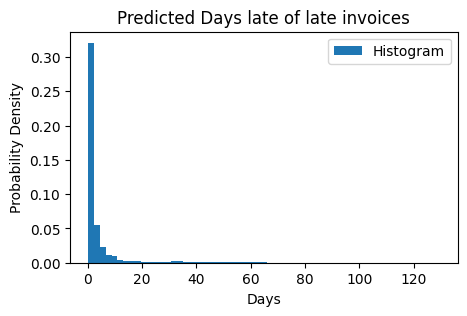

In [95]:
#Calculating the widht size of the bins in the histogram
n = len(pred_rfr)
bins = np.ceil((max(pred_rfr)-min(pred_rfr))/(3.5*np.std(pred_rfr)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(5, 3))
plt.hist(pred_rfr, bins=int(bins), density=True, label="Histogram")

plt.xlabel('Days')
plt.ylabel('Probability Density')
plt.title('Predicted Days late of late invoices')
plt.legend()
plt.show()

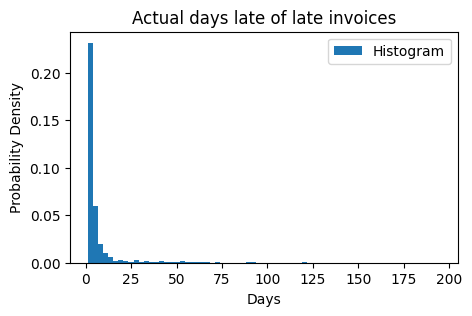

In [96]:
#Calculating the widht size of the bins in the histogram
n = len(y_test)
bins = np.ceil((max(y_test)-min(y_test))/(3.5*np.std(y_test)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(5, 3))
plt.hist(y_test, bins=int(bins), density=True, label="Histogram")

#Plotting the normal curve 
plt.xlabel('Days')
plt.ylabel('Probability Density')
plt.title('Actual days late of late invoices')
plt.legend()
plt.show()

#### Predicting on not payed invoices that was predicted to be late

In [97]:
#Doing predictions
pred_rfr = rfr.predict(df_predict_date)

#Since we already predicted they are going to be late we can change those greatar than 1
for i, x in enumerate(pred_rfr):
    if x <= 0:
        pred_rfr[i] = 1

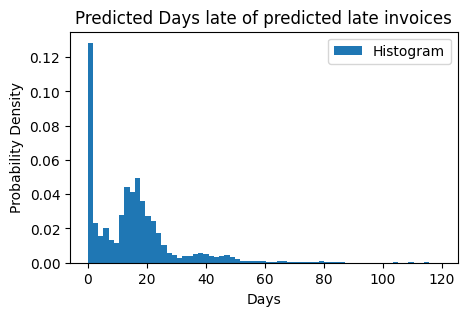

In [98]:
#Calculating the widht size of the bins in the histogram
n = len(pred_rfr)
bins = np.ceil((max(pred_rfr)-min(pred_rfr))/(3.5*np.std(pred_rfr)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(5, 3))
plt.hist(pred_rfr, bins=int(bins), density=True, label="Histogram")

plt.xlabel('Days')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Predicted Days late of predicted late invoices')
plt.show()

In [99]:
## Calculating mean and standard deviation
pred_rfr_mean = round(sum(pred_rfr)/len(pred_rfr),4)
pred_rfr_std_deviation = round(np.std(pred_rfr),4)
y_delayed_payment_days_mean = round(sum(y)/len(y),4)
y_delayed_payment_days_std_deviation = round(np.std(y),4)


print("Mean predicted days late on not payed invoices:", pred_rfr_mean)
print("Standard deviation on predicted not payed invoices:", pred_rfr_std_deviation)
print("Mean days late on late payed invoices:", y_delayed_payment_days_mean)
print("Standard deviation on late payed invoices:", y_delayed_payment_days_std_deviation)

Mean predicted days late on not payed invoices: 15.2723
Standard deviation on predicted not payed invoices: 14.3158
Mean days late on late payed invoices: 6.4467
Standard deviation on late payed invoices: 13.1339


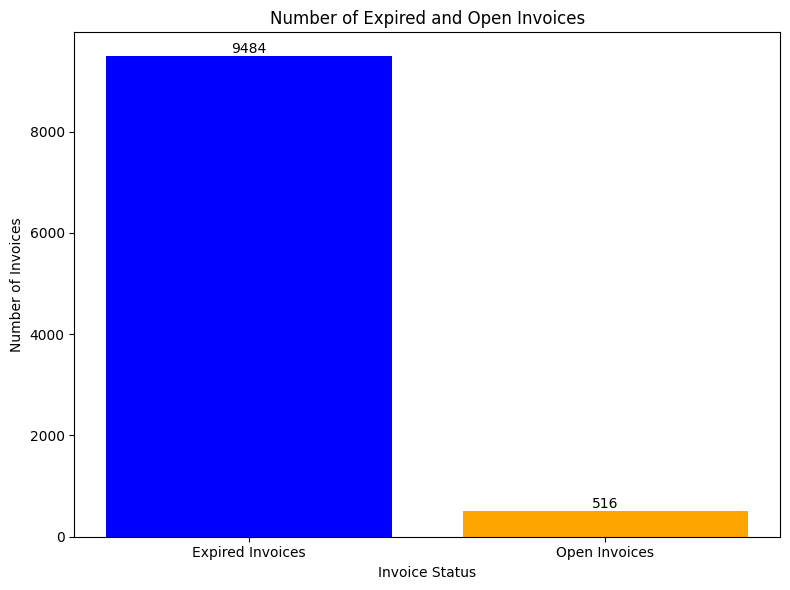

In [100]:
df_predict_looking['due_in_date'] = pd.to_datetime(df_predict_looking['due_in_date'], format='%Y%m%d')
df_predict_looking['clear_date'] = pd.to_datetime(df_predict_looking['clear_date'],  errors='coerce')
df_predict_looking['posting_date'] = pd.to_datetime(df_predict_looking['posting_date'], format='%m/%d/%Y')

num_expired_invoices = len(df_predict_looking[df_predict_looking['due_in_date'] < simulated_todays_date])
num_open_invoices = len(df_predict_looking[df_predict_looking['due_in_date'] >= simulated_todays_date])

# Data for plotting
categories = ['Expired Invoices', 'Open Invoices']
counts = [num_expired_invoices, num_open_invoices]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['blue', 'orange'])

# Add title and labels
plt.title('Number of Expired and Open Invoices')
plt.xlabel('Invoice Status')
plt.ylabel('Number of Invoices')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

## Inspect the models

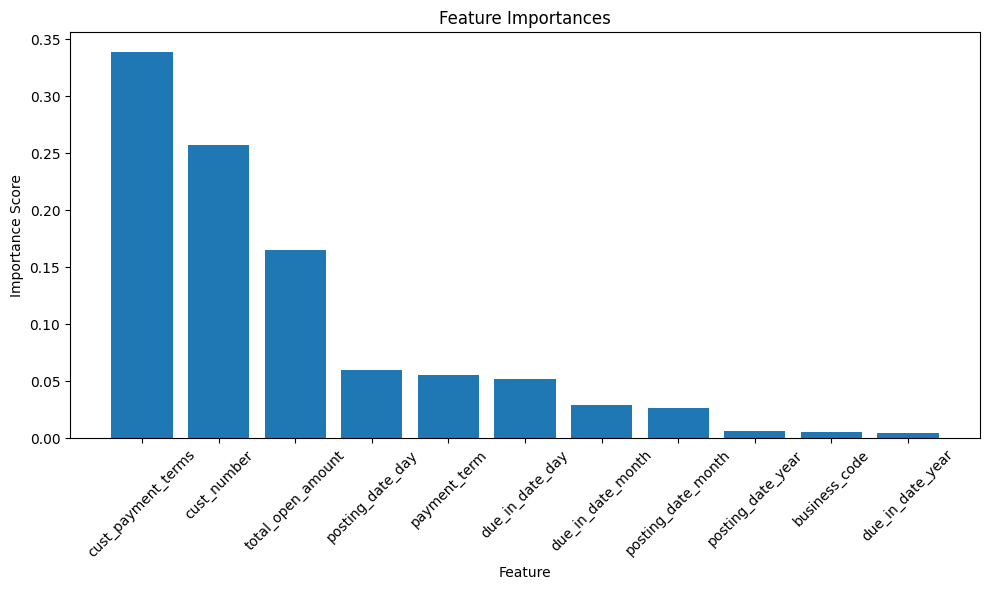

In [101]:
# Get feature importances
feature_importances = rfr.feature_importances_

# Sort features by importance
feature_names = X_train.columns  # Replace with your feature names if available
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10 , 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=45)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

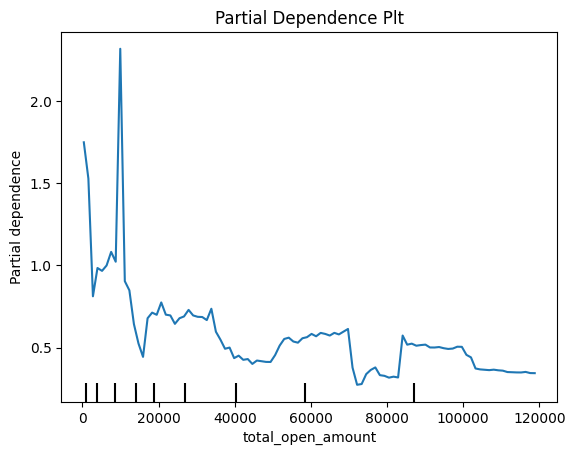

In [102]:
from sklearn.inspection import PartialDependenceDisplay

# Assuming model is your trained RandomForestRegressor and X_train is your training data
PartialDependenceDisplay.from_estimator(rfr, X_train, [2], kind='average')

plt.title("Partial Dependence Plt")
plt.show()

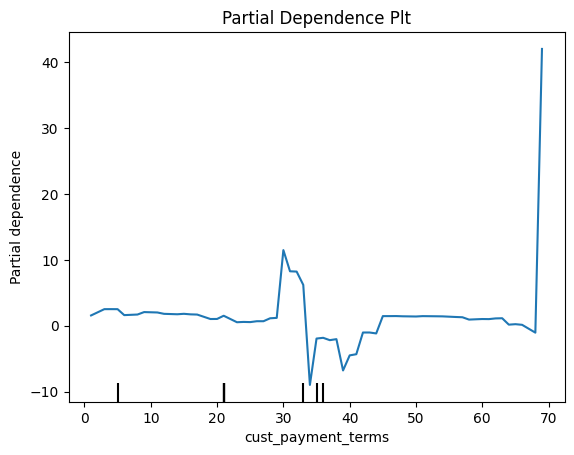

In [103]:
PartialDependenceDisplay.from_estimator(rfr, X_train, [3], kind='average')

plt.title("Partial Dependence Plt")
plt.show()

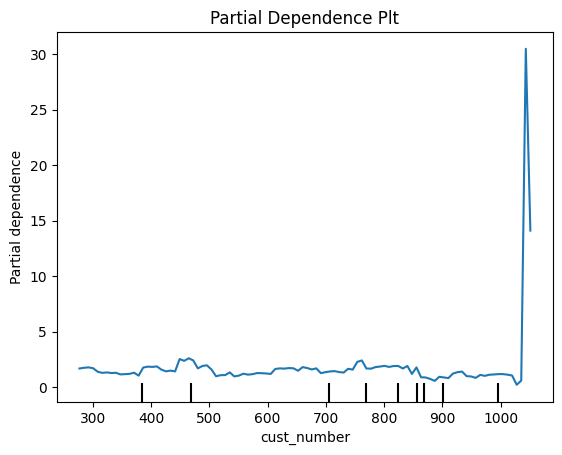

In [104]:
pdp_display  = PartialDependenceDisplay.from_estimator(rfr, X_train, [1], kind='average')

plt.title("Partial Dependence Plt")
plt.show()

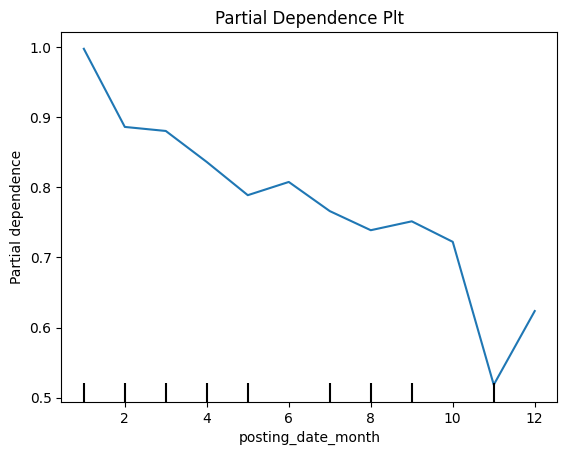

In [105]:
pdp_display  = PartialDependenceDisplay.from_estimator(rfr, X_train, [6], kind='average')

plt.title("Partial Dependence Plt")
plt.show()

From the graph we can see that invoices that have been posting earlier in the year tend to get payed later than invoices posted later in the year.
This is most likely due to companies having to report their annual accounts and not wanting any short-term receivables in their numbers. 

We can also see a spike in the middle of the year, likely for the same reason since some companies have a broken fiscal year in which they do their reporting in June.

In [106]:
dependency_values = pdp_display.lines_[0][0].get_ydata()  
feature_values = pdp_display.lines_[0][0].get_xdata() 

# Find the maximum dependency value and its corresponding feature value
max_dependency = max(dependency_values)
max_index = dependency_values.argmax()
max_feature_value = feature_values[max_index]

print(f"Maximum Dependency Value: {max_dependency}")
print(f"Feature Value with Maximum Dependency: {max_feature_value}")
halloj = df_payement_dayslow[df_payement_dayslow['cust_number'] == 1044]['delayed_payment_days']
print(halloj.count())
print(sum(halloj)/halloj.count())

Maximum Dependency Value: 0.9976311782857331
Feature Value with Maximum Dependency: 1
30
35.43333333333333


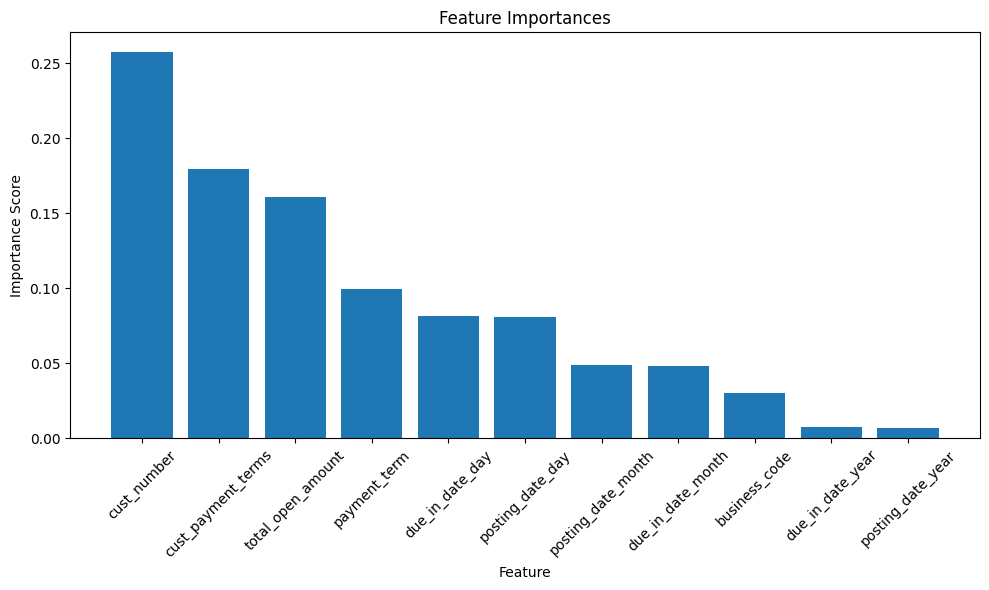

In [107]:
# Get feature importances
feature_importances = rfc.feature_importances_

# Sort features by importance
feature_names = date_X_test.columns  # Replace with your feature names if available
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=45)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()